# Task 2: News Category Classification - Colab Ready


Imports

In [1]:
import re
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

NLTK Setup

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Load Dataset

In [3]:
df_train = pd.read_csv('/content/Dataset/train.csv')
df_test = pd.read_csv('/content/Dataset/test.csv')

class_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Science'}
df_train['category'] = df_train['Class Index'].map(class_map)
df_test['category'] = df_test['Class Index'].map(class_map)

# Combine title + description
df_train['text'] = df_train['Title'] + ' ' + df_train['Description']
df_test['text'] = df_test['Title'] + ' ' + df_test['Description']

df_train = df_train[['text', 'category']]
df_test = df_test[['text', 'category']]

Text Preprocessing

In [4]:
def preprocess_text(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

Exploratory Visualization

/tmp/ipython-input-910767654.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='category', data=df_train, palette='Set2')


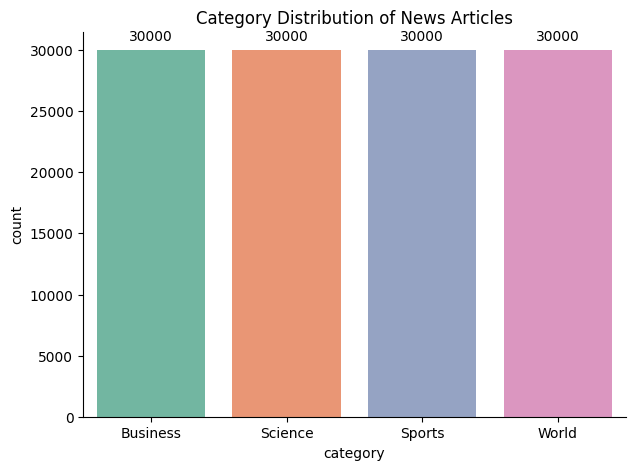

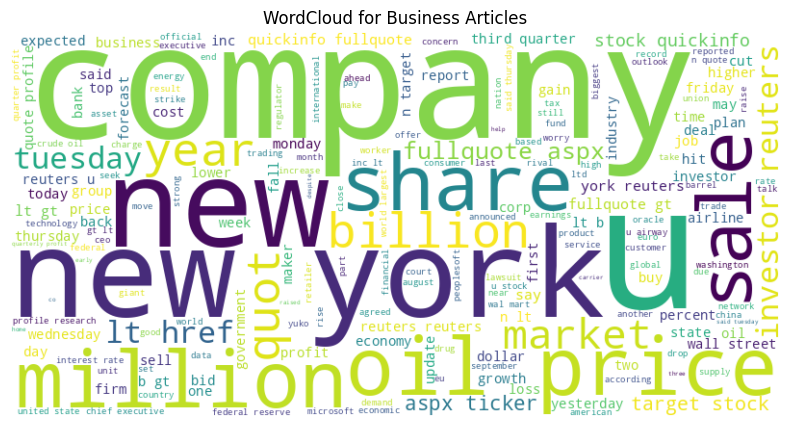

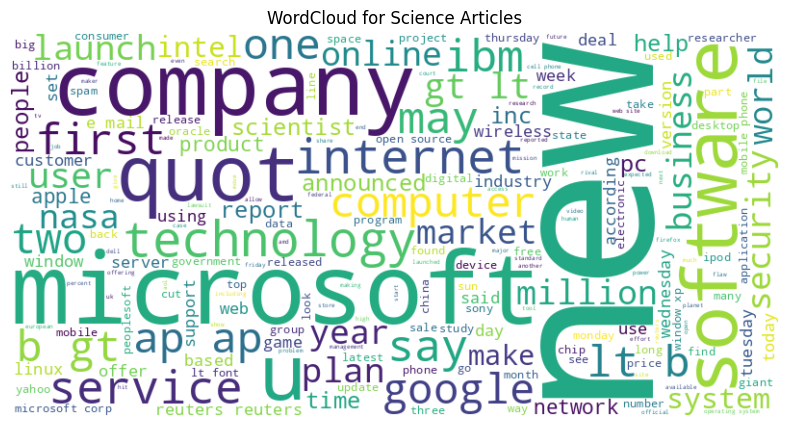

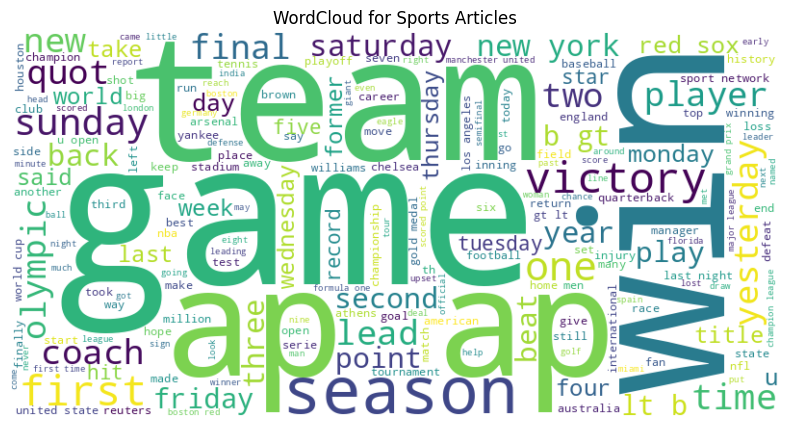

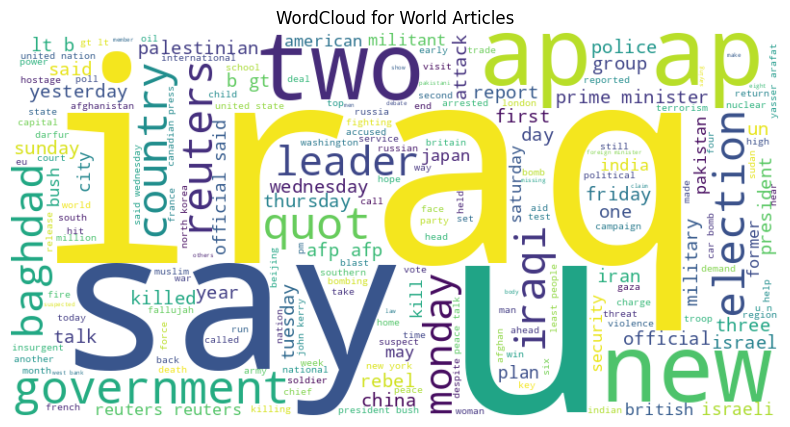

In [5]:
# Category distribution
plt.figure(figsize=(7,5))
ax = sns.countplot(x='category', data=df_train, palette='Set2')
plt.title('Category Distribution of News Articles')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
sns.despine()
plt.show()

# WordClouds per category (sampled for memory)
def plot_wordcloud_category(df, sample_size=2000):
    for category in df['category'].unique():
        reviews = df[df['category'] == category]['text']
        if len(reviews) > sample_size:
            reviews = reviews.sample(sample_size, random_state=42)
        text = ' '.join(reviews)
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud for {category} Articles')
        plt.show()

plot_wordcloud_category(df_train)

Feature Extraction

In [6]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=3)
X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_test_tfidf = tfidf.transform(df_test['text'])
y_train = df_train['category']
y_test = df_test['category']

Model Training

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Optional: limit dataset size for faster training
MAX_SAMPLES = 10000  # adjust as needed
X_train_tfidf_small = X_train_tfidf[:MAX_SAMPLES]
y_train_small = y_train[:MAX_SAMPLES]

models = {}

# ---------- Logistic Regression (SGD variant for speed) ----------
logreg = SGDClassifier(loss='log_loss', max_iter=500, n_jobs=-1, random_state=42)
logreg.fit(X_train_tfidf_small, y_train_small)
models['Logistic Regression'] = logreg

# ---------- Naive Bayes ----------
nb = MultinomialNB()
nb.fit(X_train_tfidf_small, y_train_small)
models['Naive Bayes'] = nb

# ---------- Random Forest (smaller for Colab) ----------
rf = RandomForestClassifier(
    n_estimators=30,    # fewer trees
    max_depth=10,       # limit tree depth
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_tfidf_small, y_train_small)
models['Random Forest'] = rf

# ---------- Linear SVM (fast on TF-IDF) ----------
svm = LinearSVC(max_iter=1000, random_state=42)
svm.fit(X_train_tfidf_small, y_train_small)
models['SVM'] = svm

print("✅ All models trained successfully (Colab-optimized).")


✅ All models trained successfully (Colab-optimized).


Evaluate Models


Logistic Regression Results:
Accuracy: 0.87
              precision    recall  f1-score   support

    Business       0.87      0.79      0.82      1900
     Science       0.80      0.90      0.84      1900
      Sports       0.94      0.92      0.93      1900
       World       0.89      0.88      0.88      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



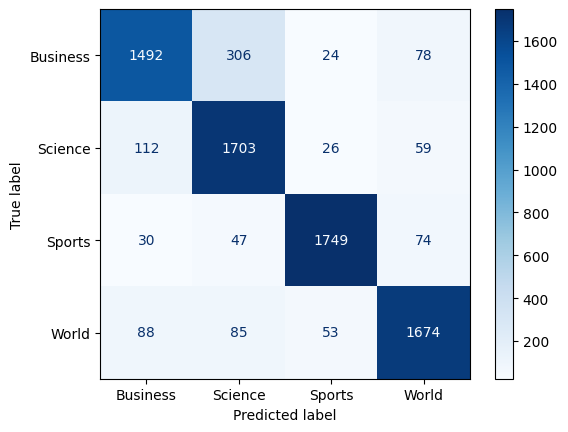


Naive Bayes Results:
Accuracy: 0.87
              precision    recall  f1-score   support

    Business       0.86      0.77      0.81      1900
     Science       0.80      0.89      0.84      1900
      Sports       0.93      0.94      0.94      1900
       World       0.89      0.88      0.88      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



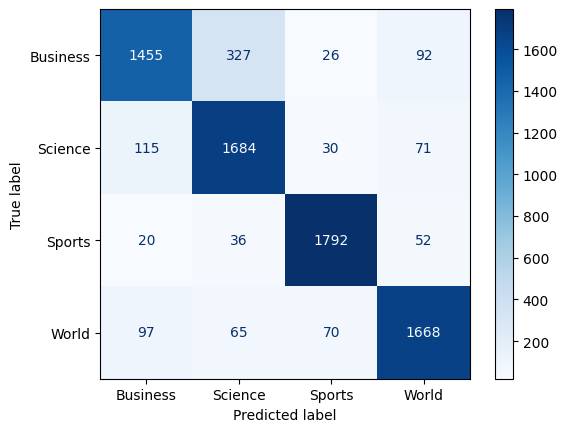


Random Forest Results:
Accuracy: 0.62
              precision    recall  f1-score   support

    Business       0.80      0.45      0.58      1900
     Science       0.42      0.90      0.57      1900
      Sports       0.94      0.45      0.61      1900
       World       0.82      0.67      0.74      1900

    accuracy                           0.62      7600
   macro avg       0.75      0.62      0.63      7600
weighted avg       0.75      0.62      0.63      7600



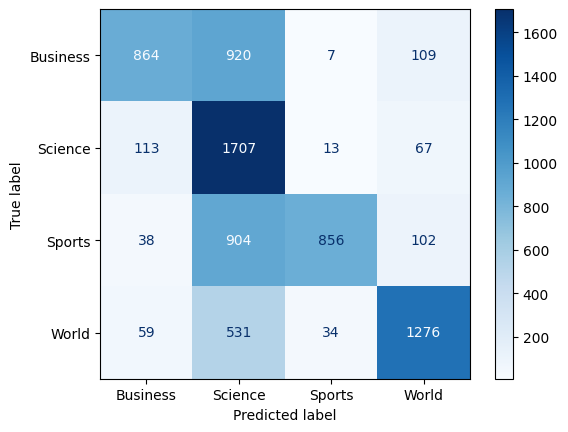


SVM Results:
Accuracy: 0.86
              precision    recall  f1-score   support

    Business       0.84      0.77      0.80      1900
     Science       0.79      0.87      0.83      1900
      Sports       0.93      0.92      0.92      1900
       World       0.87      0.87      0.87      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



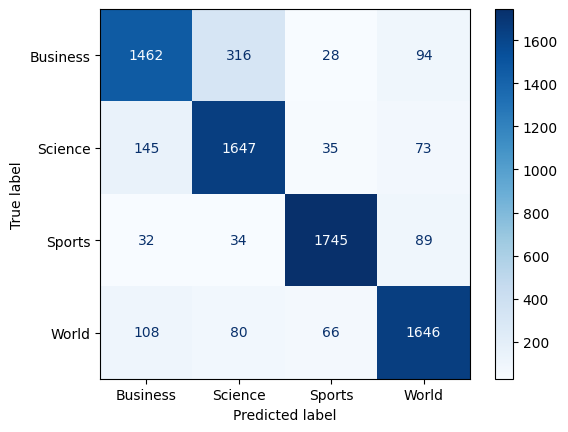

In [8]:
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    print(f'\n{name} Results:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf, y_test, cmap='Blues')
    plt.show()

Neural Network

In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

input_dim = X_train_tfidf.shape[1]
nn = Sequential([
    Dense(512, input_dim=input_dim, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(y_train_cat.shape[1], activation='softmax')
])

nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn.fit(X_train_tfidf, y_train_cat, epochs=5, batch_size=128, validation_split=0.1)

loss, acc = nn.evaluate(X_test_tfidf, y_test_cat, verbose=0)
print(f'\nNeural Network Accuracy: {acc:.2f}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 101s 118ms/step - accuracy: 0.8593 - loss: 0.4372 - val_accuracy: 0.9183 - val_loss: 0.2383
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 139s 115ms/step - accuracy: 0.9398 - loss: 0.1712 - val_accuracy: 0.9100 - val_loss: 0.2516
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 95s 113ms/step - accuracy: 0.9583 - loss: 0.1166 - val_accuracy: 0.9088 - val_loss: 0.3000
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 99s 117ms/step - accuracy: 0.9748 - loss: 0.0697 - val_accuracy: 0.9022 - val_loss: 0.3688
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 103s 122ms/step - accuracy: 0.9856 - loss: 0.0394 - val_accuracy: 0.9018 - val_loss: 0.4712

Neural Network Accuracy: 0.91


Prediction Function

In [10]:
def predict_news_category(input_text, model_choice='logistic'):
    text = preprocess_text(input_text)
    vect_text = tfidf.transform([text])
    model_choice = model_choice.lower()
    if model_choice == 'logistic':
        return logreg.predict(vect_text)[0]
    elif model_choice == 'naive_bayes':
        return nb.predict(vect_text)[0]
    elif model_choice == 'random_forest':
        return rf.predict(vect_text)[0]
    elif model_choice == 'svm':
        return svm.predict(vect_text)[0]
    elif model_choice == 'nn':
        pred = nn.predict(vect_text)
        return le.inverse_transform([np.argmax(pred)])[0]
    else:
        raise ValueError("Model choice must be: logistic, naive_bayes, random_forest, svm, nn")

Save Models

In [11]:
os.makedirs('model', exist_ok=True)
with open('model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
for name, model in models.items():
    with open(f'model/{name.replace(" ", "_").lower()}_model.pkl', 'wb') as f:
        pickle.dump(model, f)
nn.save('model/news_nn_model.h5')
print('All models and vectorizer saved successfully.')

All models and vectorizer saved successfully.


# BONUS CELLS


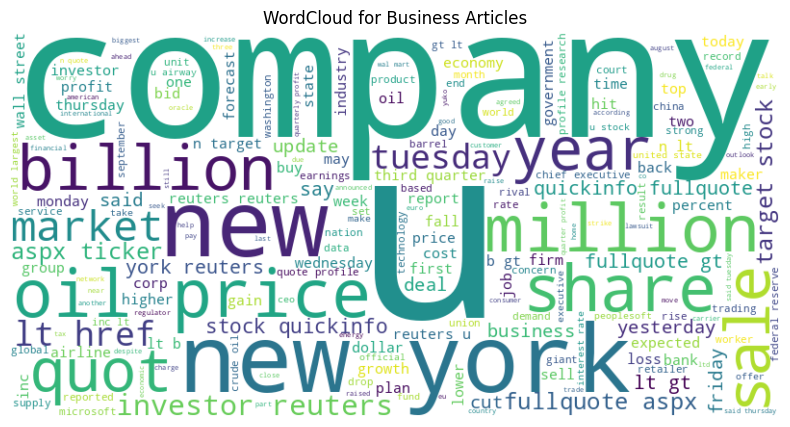

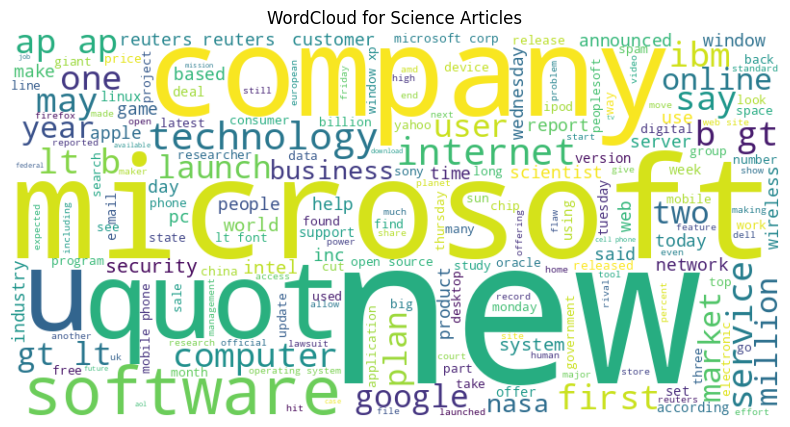

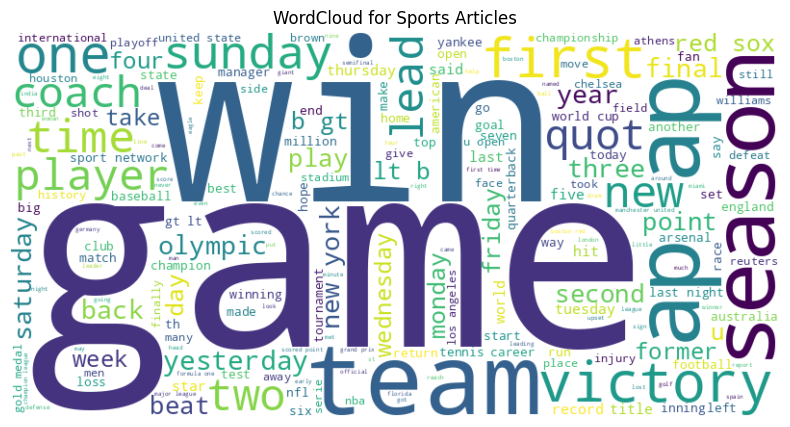

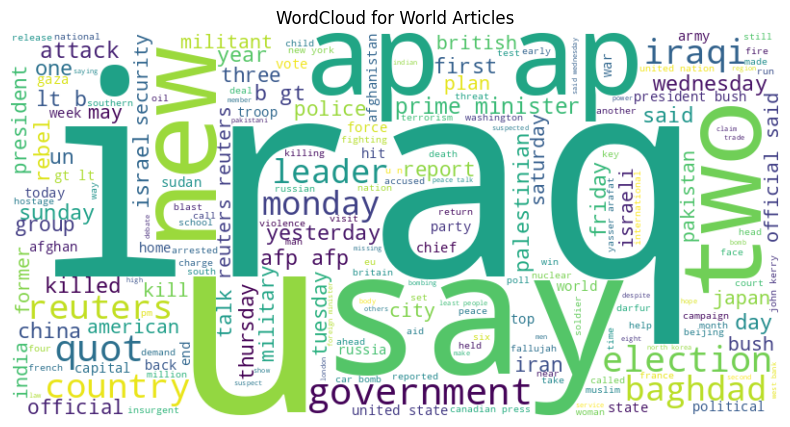

In [12]:
# BONUS 1: WordClouds per category
plot_wordcloud_category(df_train)

In [13]:
# BONUS 2: Neural Network Evaluation (Bonus)
loss, acc = nn.evaluate(X_test_tfidf, y_test_cat, verbose=0)
print(f'\nNeural Network Accuracy (Bonus): {acc:.2f}')


Neural Network Accuracy (Bonus): 0.91


In [14]:
# BONUS 3: NN Prediction example
example_text = "NASA launches new satellite to monitor climate change."
pred_category = predict_news_category(example_text, model_choice='nn')
print(f'Predicted Category (NN Bonus): {pred_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Predicted Category (NN Bonus): Science
